In [14]:
import math
import random
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from collections import namedtuple, deque
from itertools import count
from PIL import Image

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F 
import torchvision.transforms as T 
from torch.distributions import Categorical

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
import pandas as pd
import utils

TS = 48
MPATH = '__pycache__/a2c_net.pt'
DO_TRAIN = False

# samples = list(range(201, 211)) #[201, 202, 203]
samples = [221, 243, 232, 202, 204, 214, 205, 239, 248, 273, 282, 289]
data_train, df_date = utils.load_data('AusGrid_preprocess.csv', samples, TS)

(17520, 2)
(17520, 2)
(17520, 2)
(17520, 2)
(17520, 2)
(17520, 2)
(17520, 2)
(17520, 2)
(17520, 2)
(17520, 2)


State : [PV.gen, LD, PV.charge, PV.dischare, BS, GD, COST]
- PV.gen : PV generatoin power
- LD : Load consumption power
- PV.charge : Battery charging power
- PV.dischare : Battery discharging power
- BS : Battery status
- GD : Grid imort(+)/export(-) power
- COST : Cost for power

Action : [0, 1]
- 0 : discharging
- 1 : charging

Cost funciton(Reward)
- Self consumption : (PV - PV.charge + PV.dischare - GD) / PV
- Self sufficency : (PV - PV.charge + PV.dischare - GD) / LD

In [16]:
class A2C(nn.Module):

    def __init__(self, n_observations, n_actions):
        super(A2C, self).__init__()
        self.num_actions = n_actions
        DIM1 = 256
        DIM2 = 128
        DIM3 = 64
        
        self.layer1_actor = nn.Linear(n_observations, DIM1)
        self.layer1_critic = nn.Linear(n_observations, DIM1)
        
        self.layer2_actor = nn.Linear(DIM1, DIM2)
        self.layer2_critic = nn.Linear(DIM1, DIM2)

        # self.layer3_actor = nn.Linear(DIM2, DIM3)
        # self.layer3_critic = nn.Linear(DIM2, DIM3)
        
        self.layerF_actor = nn.Linear(DIM2, n_actions)
        self.layerF_critic = nn.Linear(DIM2, 1)

    # Called with either one element to determine next action, or a batch
    # during optimization. Returns tensor([[left0exp,right0exp]...]).
    def forward(self, x):
        px = F.relu(self.layer1_actor(x))
        px = F.relu(self.layer2_actor(px))
        # px = F.relu(self.layer3_actor(px))
        policy_dist = F.softmax(self.layerF_actor(px), dim=-1)

        vx = F.relu(self.layer1_critic(x))
        vx = F.relu(self.layer2_critic(vx))
        # vx = F.relu(self.layer3_critic(vx))
        value = self.layerF_critic(vx)
        
        return value, policy_dist

In [17]:
GAMMA = 0.9
MAX_GDNORM = 0.1

n_observaons = 7
print(n_observaons)
n_actions = 2
a2c_net = A2C(n_observaons, n_actions).to(device)
optimizer = optim.AdamW(a2c_net.parameters(), lr=1e-5)

7


In [ ]:
if DO_TRAIN == True:
    all_lengths = []
    average_lengths = []
    all_rewards = []
    all_sc_ss = []

    entropy_term = 0

    loop = 10    
    num_episodes = len(data_train)

    for l in range(loop):
        for i_episode in range(num_episodes):
            capacities = utils.cal_stds(data_train[i_episode%len(data_train)])
            for c in capacities:
                env = utils.ENV_BATT(data_train[i_episode%len(data_train)], max(0, c))
                state = env.reset()    

                log_probs = []
                values = []
                rewards = []
                
                total_export = 0.0
                total_import = 0.0
                total_pv = 0.0
                total_ld = 0.0
                    
                for i in range(env.data_env.shape[0]):
                    value, policy_dist = a2c_net.forward(state)
                    value = value.detach().numpy()[0]
                    dist = policy_dist.detach().numpy()
                    action = np.random.choice(n_actions, p=np.squeeze(dist))
                    
                    log_prob = torch.log(policy_dist.squeeze(0)[action])
                    entropy = -np.sum(dist * np.log(dist + 1e-16))
                    new_state, reward, done = env.step(action)

                    rewards.append(reward.squeeze(0))
                    values.append(value)
                    log_probs.append(log_prob)
                    entropy_term += entropy
                    state = new_state

                    total_export += state.numpy()[5] if state.numpy()[5] < 0 else 0
                    total_import += state.numpy()[5] if state.numpy()[5] > 0 else 0
                    total_pv += state.numpy()[0]
                    total_ld += state.numpy()[1]

                    # if done:
                    if (i + 1) % TS == 0:
                        Qval, _ = a2c_net.forward(new_state)
                        Qval = Qval.detach().numpy()[0]
                        all_rewards.append(np.sum(rewards))
                        all_lengths.append(i)
                        average_lengths.append(np.mean(all_lengths[-10:]))
                        # print("episode: {}, reward: {}, total length: {}, average length: {} \n".format(i_episode, np.sum(rewards), i, average_lengths[-1]))

                        # compute Q values
                        Qvals = np.zeros_like(values)
                        for t in reversed(range(len(rewards))):
                            Qval = rewards[t] + GAMMA * Qval
                            Qvals[t] = Qval

                        #update actor critic
                        values = torch.FloatTensor(values)
                        Qvals = torch.FloatTensor(Qvals)
                        log_probs = torch.stack(log_probs)

                        advantage =  Qvals - values
                        actor_loss = -(log_probs * advantage).mean()
                        critic_loss = 0.5 * advantage.pow(2).mean()
                        ac_loss = actor_loss + critic_loss - 0.001 * entropy_term
                        # print(Qvals.mean().item(), advantage.mean().item(), actor_loss.item(), critic_loss.item(), 0.001*entropy_term.item())
                        
                        optimizer.zero_grad()
                        ac_loss.backward()
                        for param in a2c_net.parameters():
                            if param.grad == None:
                                break
                            param.grad.data.clamp_(-1, 1)
                        optimizer.step()

                        log_probs = []
                        values = []
                        rewards = []
                        # entropy_term = 0.0

                sc = (total_pv + total_export)/total_pv
                ss = (total_ld - total_import)/total_ld
                all_sc_ss.append([sc, ss])
                print(l, i_episode, 'sc and ss', sc, ss)


0 sc and ss 0.7652817032580334 0.2658987682505678
1 sc and ss 0.7018965221603053 0.4071563210554711
2 sc and ss 0.7844613148217073 0.2304266368394571
3 sc and ss 0.8151634472619036 0.39112672362807444
4 sc and ss 0.5580757828671621 0.46230645284931615
5 sc and ss 0.6809473763806695 0.2606484190051539
6 sc and ss 0.8342127741647184 0.3478487006358015
7 sc and ss 0.7596788844676043 0.3351211437544577
8 sc and ss 0.8411022475530759 0.20416682650660334
9 sc and ss 0.7034721942930643 0.42186867939457223
10 sc and ss 0.760091499945311 0.2640954209286405
11 sc and ss 0.7052330537271602 0.40909177721892165
12 sc and ss 0.7781194485723181 0.22856378539861572
13 sc and ss 0.784451004780209 0.37639046785365665
14 sc and ss 0.6115640492549824 0.5065556735839621
15 sc and ss 0.6717253609620829 0.2571184786527303
16 sc and ss 0.8297921687125736 0.34600540366185745
17 sc and ss 0.7546003839355818 0.3328808381166875
18 sc and ss 0.8348110322160464 0.20263971428632008
19 sc and ss 0.6828527970484075 0.

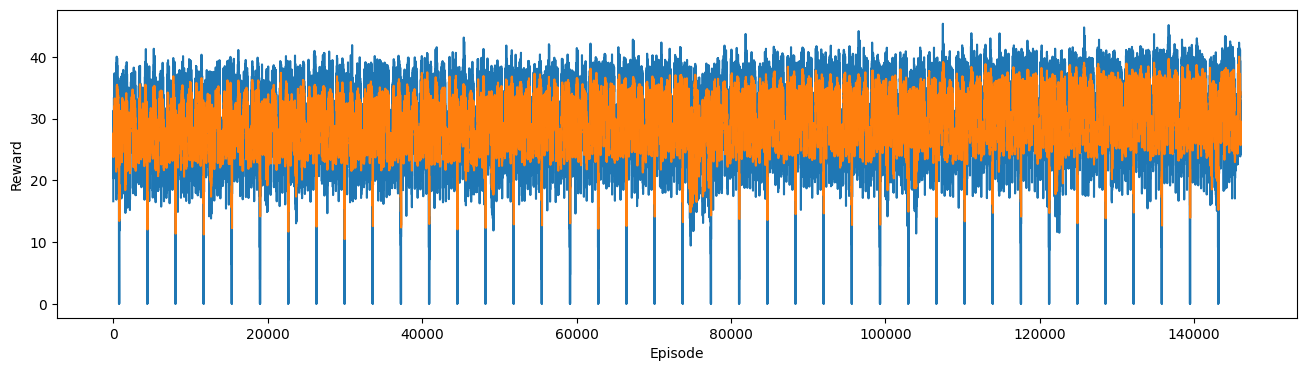

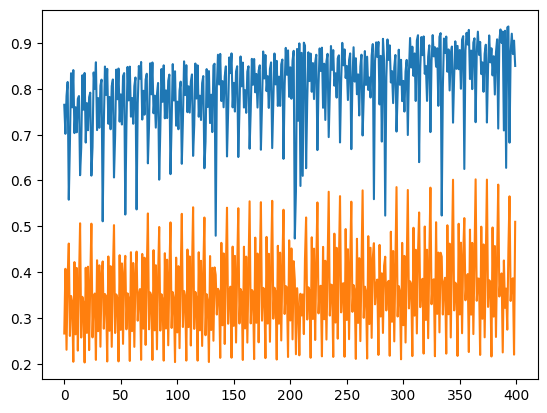

In [ ]:
# Plot results
if DO_TRAIN == True:
    smoothed_rewards = pd.Series.rolling(pd.Series(all_rewards), 10).mean()
    smoothed_rewards = [elem for elem in smoothed_rewards]
    plt.figure(figsize=(16, 4))
    plt.plot(all_rewards)
    plt.plot(smoothed_rewards)
    plt.plot()
    plt.xlabel('Episode')
    plt.ylabel('Reward')
    plt.show()

    plt.plot(np.array(all_sc_ss)[:, 0])
    plt.plot(np.array(all_sc_ss)[:, 1])
    plt.show()

In [20]:
data_test, df_date = utils.load_data('AusGrid_preprocess.csv', [1], TS)
data_test = data_test[0]
stds = utils.cal_stds(data_test)
print(stds)

(17520, 2)


In [ ]:
capacity = stds[3]
env = utils.ENV_BATT(data_test, max(0, capacity))
state = env.reset()    
state = torch.tensor(state).unsqueeze(0)

a2c_net.load_state_dict(torch.load(MPATH, weights_only=True))

df_out = pd.DataFrame(columns=['PV', 'LD', 'PV.C', 'PV.D', 'BT', 'GD', 'COST', 'AC', 'RD'])

with torch.no_grad():
    for i in range(env.data_env.shape[0]):
        _, logits = a2c_net.forward(state)
        # prob = F.softmax(logits, dim=1).data
        action = torch.argmax(logits, dim=1).numpy()[0]
        print(logits, action)
        
        observation, reward, done=env.step(action.item())
        reward = torch.tensor([reward], device=device)
        next_state = observation.clone().detach().unsqueeze(0)
        st = next_state.numpy().squeeze(0)
        at = action.item()
        # print('Current x : ', t, 'Action :', at, ', y : ', next_state, 'reward :', reward.item())

        st = np.concatenate((st, np.array([at-1, reward.item()])))
        df_out.loc[i] = st
        state = next_state


tensor([[0.4188, 0.5812]]) 1
tensor([[0.7384, 0.2616]]) 0
tensor([[0.7220, 0.2780]]) 0
tensor([[0.6708, 0.3292]]) 0
tensor([[0.6505, 0.3495]]) 0
tensor([[0.6687, 0.3313]]) 0
tensor([[0.6733, 0.3267]]) 0
tensor([[0.8057, 0.1943]]) 0
tensor([[0.6892, 0.3108]]) 0
tensor([[0.4480, 0.5520]]) 1
tensor([[0.4763, 0.5237]]) 1
tensor([[0.6868, 0.3132]]) 0
tensor([[0.5638, 0.4362]]) 0
tensor([[0.4366, 0.5634]]) 1
tensor([[0.4588, 0.5412]]) 1
tensor([[0.4331, 0.5669]]) 1
tensor([[0.4817, 0.5183]]) 1
tensor([[0.4946, 0.5054]]) 1
tensor([[0.3608, 0.6392]]) 1
tensor([[0.3667, 0.6333]]) 1
tensor([[0.2536, 0.7464]]) 1
tensor([[0.1799, 0.8201]]) 1
tensor([[0.2120, 0.7880]]) 1
tensor([[0.1536, 0.8464]]) 1
tensor([[0.2313, 0.7687]]) 1
tensor([[0.2162, 0.7838]]) 1
tensor([[0.4204, 0.5796]]) 1
tensor([[0.1197, 0.8803]]) 1
tensor([[0.0771, 0.9229]]) 1
tensor([[0.0904, 0.9096]]) 1
tensor([[0.1979, 0.8021]]) 1
tensor([[0.2356, 0.7644]]) 1
tensor([[0.5736, 0.4264]]) 0
tensor([[0.5345, 0.4655]]) 0
tensor([[0.543

/var/folders/hv/t1mrtt815b713sd0fqxv51hm0000gn/T/ipykernel_6472/1794212241.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  state = torch.tensor(state).unsqueeze(0)


tensor([[0.5140, 0.4860]]) 0
tensor([[0.4797, 0.5203]]) 1
tensor([[0.7569, 0.2431]]) 0
tensor([[0.4745, 0.5255]]) 1
tensor([[0.5834, 0.4166]]) 0
tensor([[0.5351, 0.4649]]) 0
tensor([[0.4417, 0.5583]]) 1
tensor([[0.4535, 0.5465]]) 1
tensor([[0.4646, 0.5354]]) 1
tensor([[0.4575, 0.5425]]) 1
tensor([[0.5640, 0.4360]]) 0
tensor([[0.4344, 0.5656]]) 1
tensor([[0.4491, 0.5509]]) 1
tensor([[0.4928, 0.5072]]) 1
tensor([[0.7650, 0.2350]]) 0
tensor([[0.5854, 0.4146]]) 0
tensor([[0.4355, 0.5645]]) 1
tensor([[0.4844, 0.5156]]) 1
tensor([[0.6805, 0.3195]]) 0
tensor([[0.7933, 0.2067]]) 0
tensor([[0.6212, 0.3788]]) 0
tensor([[0.6653, 0.3347]]) 0
tensor([[0.4549, 0.5451]]) 1
tensor([[0.4869, 0.5131]]) 1
tensor([[0.5709, 0.4291]]) 0
tensor([[0.6130, 0.3870]]) 0
tensor([[0.3163, 0.6837]]) 1
tensor([[0.2133, 0.7867]]) 1
tensor([[0.1897, 0.8103]]) 1
tensor([[0.1352, 0.8648]]) 1
tensor([[0.1335, 0.8665]]) 1
tensor([[0.1323, 0.8677]]) 1
tensor([[0.1071, 0.8929]]) 1
tensor([[0.1279, 0.8721]]) 1
tensor([[0.086

                      PV     LD   BT   AC     GD        RD
2012-07-01 00:30:00  0.0  0.855  5.0  0.0  0.855  0.000000
2012-07-01 01:00:00  0.0  0.786  5.0 -1.0  0.786  0.000000
2012-07-01 01:30:00  0.0  0.604  5.0 -1.0  0.604  0.000000
2012-07-01 02:00:00  0.0  0.544  5.0 -1.0  0.544  0.000000
2012-07-01 02:30:00  0.0  0.597  5.0 -1.0  0.597  0.000000
...                  ...    ...  ...  ...    ...       ...
2012-07-05 22:30:00  0.0  0.414  5.0 -1.0  0.414  0.487934
2012-07-05 23:00:00  0.0  0.932  5.0 -1.0  0.932  0.485515
2012-07-05 23:30:00  0.0  0.070  5.0 -1.0  0.070  0.485307
2012-07-06 00:00:00  0.0  0.094  5.0  0.0  0.094  0.485048
2012-07-06 00:30:00  0.0  0.056  5.0  0.0  0.056  0.484903

[241 rows x 6 columns]


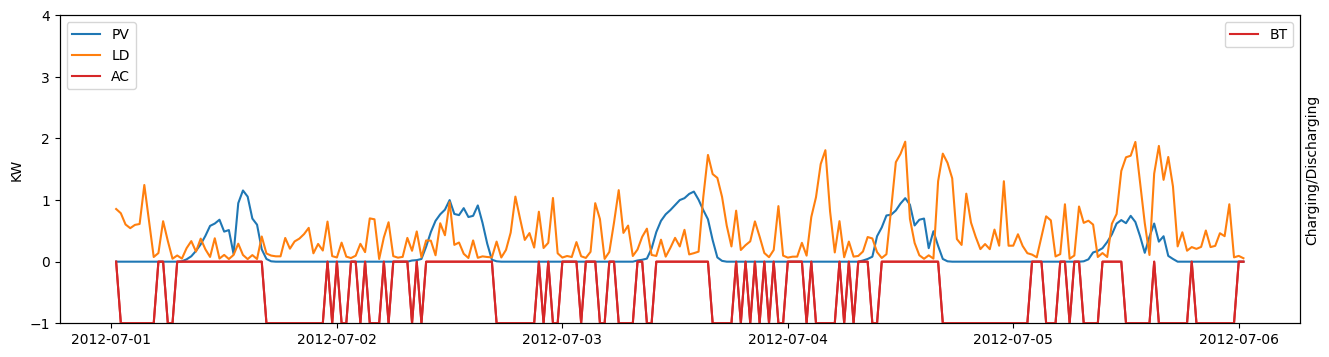

In [22]:
start_pos = 0
duration = TS*5
df_dis = df_out[['PV', 'LD', 'BT', 'AC', 'GD', 'RD']]
df_dis = df_dis.set_index(pd.Index(df_date.values))

pv =  df_dis['PV'].loc[df_date.values[start_pos]:df_date.values[start_pos+duration]].values
ld =  df_dis['LD'].loc[df_date.values[start_pos]:df_date.values[start_pos+duration]].values
bt =  df_dis['BT'].loc[df_date.values[start_pos]:df_date.values[start_pos+duration]].values
ac =  df_dis['AC'].loc[df_date.values[start_pos]:df_date.values[start_pos+duration]].values

fig, ax1 = plt.subplots(figsize=(16, 4))
ax1.plot(df_date.values[start_pos:start_pos+duration+1], pv, label='PV', color='#1f77b4')
ax1.plot(df_date.values[start_pos:start_pos+duration+1], ld, label='LD', color='#ff7f0e')
ax1.plot(df_date.values[start_pos:start_pos+duration+1], ac, label='AC', color='#d62728')
ax1.legend(loc='upper left')
ax1.set_ylabel('KW')
ax1.set_ylim(-1, 4)

ax2 = ax1.twinx()
ax2.plot(df_date.values[start_pos:start_pos+duration+1], ac, label='BT', color='#d62728')
ax2.legend(loc='upper right')
ax2.set_ylabel('Charging/Discharging')
ax2.set_yticks([])
ax2.set_ylim(-1, 4)

# ax = df_dis[['PV', 'LD', 'BT', 'AC']].loc[df_date.values[start_pos]:df_date.values[start_pos+duration]].plot(figsize=(16,5))
# ax.set_ylim(-1, 3)
# ax.set_ylabel('KW')
print(df_dis.loc[df_date.values[start_pos]:df_date.values[start_pos+duration]])
plt.show()

Text(0, 0.5, 'KW')

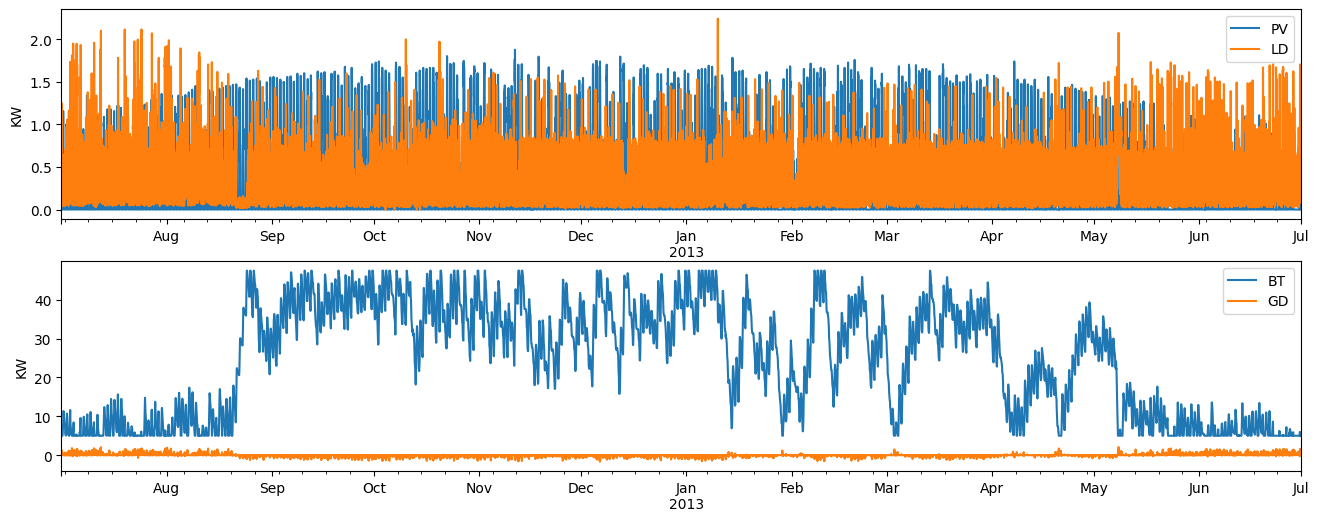

In [23]:
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(16,6))
df_dis[['PV', 'LD']].plot(ax=axes[0])
df_dis[['BT', 'GD']].plot(ax=axes[1])
# df_dis[['AC']].plot(ax=axes[1])

axes[0].set_ylabel('KW')
axes[1].set_ylabel('KW')

In [24]:
Egen = df_out['PV'].sum()
print(Egen, 'KW')
Eload = df_out['LD'].sum()
print(Eload, 'KW')
GDimport = df_out[df_out['GD'] > 0]['GD'].sum()
print(GDimport)
GDexport = df_out[df_out['GD'] < 0]['GD'].sum()
print(GDexport)

SC = (Egen + GDexport)/Egen
SS = (Eload - GDimport)/Eload
print('SC :', SC)
print('SS :', SS)

5115.207006187178 KW
5279.884002253413 KW
997.9569998948136
-833.2799999905983
SC : 0.8370975018249132
SS : 0.8109888400069218


[   0.            0.            0.         ... -833.27999999 -833.27999999
 -833.27999999]


/var/folders/hv/t1mrtt815b713sd0fqxv51hm0000gn/T/ipykernel_6472/1945581510.py:8: RuntimeWarning: invalid value encountered in divide
  ss =  (c_pv + c_ex) / c_pv


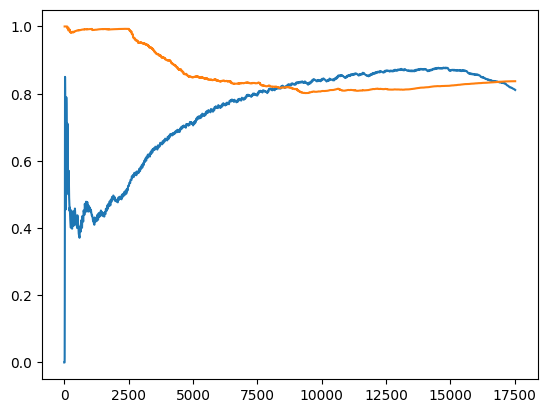

In [25]:
c_pv = np.cumsum(df_out['PV'].values)
c_ld = np.cumsum(df_out['LD'].values)
c_ex = df_out['GD'].values
c_ex[c_ex > 0] = 0
c_ex = np.cumsum(c_ex)

sc =  (c_pv + c_ex) / c_ld
ss =  (c_pv + c_ex) / c_pv

sc[np.isnan(sc)] = 0
print(c_ex)
# plt.plot(c_pv)
# plt.plot(c_ld)
# plt.plot(c_ex)
plt.plot(sc)
plt.plot(ss)

In [26]:
import numpy as np
import matplotlib.pyplot as plt
from ipywidgets import interact
 
max_len = len(df_out)

pv =  df_out['PV'].iloc[:].values
ld =  df_out['LD'].iloc[:].values
bt =  df_out['BT'].iloc[:].values
ac =  df_out['AC'].iloc[:].values
gd =  df_out['GD'].iloc[:].values
# ct =  df_out['COST'].iloc[:].values

def interactive_plot(window, start):    
    window *= 48
    start *= 48
    fig, ax1 = plt.subplots(figsize=(16, 5))    
    ax1.plot(df_date.values, pv, label='PV', color='#1f77b4')
    ax1.plot(df_date.values, ld, label='LD', color='#ff7f0e')
    ax1.plot(df_date.values, ac, label='AC', color='#d62728')
    ax1.plot(df_date.values, gd, label='GD', color='black')
    # ax1.plot(df_date.values, ct, label='COST', color='grey')
    ax1.legend(loc='upper left')
    ax1.set_ylabel('KW')

    ax2 = ax1.twinx()
    ax2.plot(df_date.values, bt, label='BT', color='#2ca02c')
    ax2.legend(loc='upper right')
    ax2.set_ylabel('KW')
    
    start = min(start, max_len-window)
    ax1.set_xlim(df_date.values[start], df_date.values[start+window-1])
    
    plt.show()

 
 
interact(interactive_plot, window=(1, 10, 1), start=(0, 365, 1))

interactive(children=(IntSlider(value=5, description='window', max=10, min=1), IntSlider(value=182, descriptio…

<function __main__.interactive_plot(window, start)>